In [20]:
# Import the necessary modules
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Define a new class that inherits from nn.Module
class VariableNetwork(nn.Module):
    # Define the constructor that takes the model as an argument
    def __init__(self, model):
        # Call the parent constructor
        super().__init__()
        # Assign the model to an attribute
        self.model = model
    
    # Override the forward function
    def forward(self, x):
        # Loop over the layers in the ModuleList
        for layer in self.model:
            # Apply the layer to the input
            x = layer(x)
        # Return the final output
        return x


# Define the functions to be approximated
def f(x1, x2, x3):
    return x1 + x2 + x3

def g(x1, x2, x3):
    return x1**2 + x2**3 + 0.5 * x3

def h(x1, x2, x3):
    return x3 * x1**(x2)


In [21]:
# Define the range and step size for the input variables
x1_range = (0, 10)
x2_range = (0, 10)
x3_range = (0, 10)
dx = 0.5

# Generate the input data by sampling uniformly from the ranges
x1 = np.arange(*x1_range, dx)
x2 = np.arange(*x2_range, dx)
x3 = np.arange(*x3_range, dx)
X1, X2, X3 = np.meshgrid(x1, x2, x3)
X = np.stack([X1.flatten(), X2.flatten(), X3.flatten()], axis=1)

# Compute the output data by applying the functions
Y_f = f(X[:, 0], X[:, 1], X[:, 2])
Y_g = g(X[:, 0], X[:, 1], X[:, 2])
Y_h = h(X[:, 0], X[:, 1], X[:, 2])

# Convert the input and output data to torch tensors
X = torch.from_numpy(X).float()
Y_f = torch.from_numpy(Y_f).float().unsqueeze(1)
Y_g = torch.from_numpy(Y_g).float().unsqueeze(1)
Y_h = torch.from_numpy(Y_h).float().unsqueeze(1)

# Split the data into train and test sets (80% train, 20% test)
train_size = int(0.8 * len(X))
test_size = len(X) - train_size
X_train, X_test = torch.utils.data.random_split(X, [train_size, test_size])
Y_f_train, Y_f_test = torch.utils.data.random_split(Y_f, [train_size, test_size])
Y_g_train, Y_g_test = torch.utils.data.random_split(Y_g, [train_size, test_size])
Y_h_train, Y_h_test = torch.utils.data.random_split(Y_h, [train_size, test_size])


In [22]:
# Let us have a variable number of hidden layers.
# Define a function to create a neural network with given hyperparameters
def create_network(input_size, output_size, hidden_sizes, activations, output_activation=None):
    # Create a ModuleList to hold the layers
    model = nn.ModuleList()
    # Loop over the hidden sizes and activations
    for hidden_size, activation in zip(hidden_sizes, activations):
        # Add a linear layer with the input size and hidden size
        model.append(nn.Linear(input_size, hidden_size))
        # Add an activation layer with the given activation function
        model.append(activation())
        # Update the input size for the next layer
        input_size = hidden_size
    # Add the final output layer with the output size
    model.append(nn.Linear(input_size, output_size))
    # If an output activation function is specified, add it to the model
    if output_activation:
        model.append(output_activation())
    # Return the model
    return model



In [23]:
# Define a function to train a neural network with given hyperparameters and data
def train_network(model, optimizer, loss_fn, batch_size, epochs,
                  X_train, Y_train, X_test=None, Y_test=None):
    # Create a data loader for the training data
    train_loader = DataLoader(
        dataset=torch.utils.data.TensorDataset(X_train, Y_train),
        batch_size=batch_size,
        shuffle=True
    )
    # Initialize a list to store the training losses
    train_losses = []
    # Initialize a list to store the test losses if test data is given
    if X_test is not None and Y_test is not None:
        test_losses = []
    # Loop over the number of epochs
    for epoch in range(epochs):
        # Initialize a variable to store the running loss for this epoch
        running_loss = 0.0
        # Loop over the batches of training data
        for inputs, targets in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass: compute the outputs from the inputs
            outputs = model(inputs)
            # Compute the loss from the outputs and targets
            loss = loss_fn(outputs, targets)
            # Backward pass: compute the gradients from the loss
            loss.backward()
            # Update the parameters using the optimizer
            optimizer.step()
            # Accumulate the running loss
            running_loss += loss.item()
        # Compute and append the average training loss for this epoch
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        # Print the progress
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")
        # If test data is given, compute and append the test loss for this epoch
        if X_test is not None and Y_test is not None:
            # Compute the outputs from the test inputs
            outputs = model(X_test)
            # Compute the loss from the outputs and test targets
            loss = loss_fn(outputs, Y_test)
            # Append the test loss
            test_loss = loss.item()
            test_losses.append(test_loss)
            # Print the progress
            print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}")
    # Return the train and test losses if test data is given, otherwise return only train losses
    if X_test is not None and Y_test is not None:
        return train_losses, test_losses
    else:
        return train_losses

In [31]:
# Define a function to plot the losses during training
def plot_losses(train_losses, test_losses=None, function_name=None, hyperparameters=""):
    # Create a figure and an axis
    fig, ax = plt.subplots(figsize=(8, 6))
    # Plot the train losses
    ax.plot(train_losses, label="Train Loss")
    # If test losses are given, plot them as well
    if test_losses is not None:
        ax.plot(test_losses, label="Test Loss")
    # Set the title, labels, and legend
    ax.set_title(f"Losses during Training ({hyperparameters})")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    # Save and show the plot
    # Use format method to insert hyperparameters into file name
    plt.savefig(f"losses_{function_name}_{hyperparameters}.png")
    plt.show()

In [32]:
# Define a function to plot the predictions versus the true values
def plot_predictions(model, X, Y_true, function_name, hyperparameters=""):
    # Create a figure and an axis
    fig, ax = plt.subplots(figsize=(8, 6))
    # Compute the predictions from the inputs
    Y_pred = model(X).detach().numpy()
    # Plot the predictions and the true values as scatter plots
    ax.scatter(Y_true, Y_pred, label="Predictions", s=2, alpha=0.3)
    ax.scatter(Y_true, Y_true, label="True Values", s=2, alpha=0.3)
    # Set the title, labels, and legend
    ax.set_title(f"Predictions versus True Values ({hyperparameters})")
    ax.set_xlabel("True Value")
    ax.set_ylabel("Predicted Value")
    ax.legend()
    # Save and show the plot
    # Use format method to insert hyperparameters into file name
    plt.savefig(f"predictions_{function_name}_{hyperparameters}.png")
    plt.show()

Approximating function f
Epoch 1, Train Loss: 36.5325
Epoch 1, Test Loss: 1.1685
Epoch 2, Train Loss: 0.5423
Epoch 2, Test Loss: 0.2309
Epoch 3, Train Loss: 0.1320
Epoch 3, Test Loss: 0.1032
Epoch 4, Train Loss: 0.0488
Epoch 4, Test Loss: 0.0433
Epoch 5, Train Loss: 0.0327
Epoch 5, Test Loss: 0.0380
Epoch 6, Train Loss: 0.0313
Epoch 6, Test Loss: 0.0212
Epoch 7, Train Loss: 0.0197
Epoch 7, Test Loss: 0.0140
Epoch 8, Train Loss: 0.0157
Epoch 8, Test Loss: 0.0104
Epoch 9, Train Loss: 0.0150
Epoch 9, Test Loss: 0.0129
Epoch 10, Train Loss: 0.0170
Epoch 10, Test Loss: 0.0075
Epoch 11, Train Loss: 0.0127
Epoch 11, Test Loss: 0.0127
Epoch 12, Train Loss: 0.0083
Epoch 12, Test Loss: 0.0185
Epoch 13, Train Loss: 0.0081
Epoch 13, Test Loss: 0.0063
Epoch 14, Train Loss: 0.0138
Epoch 14, Test Loss: 0.0113
Epoch 15, Train Loss: 0.0111
Epoch 15, Test Loss: 0.0060
Epoch 16, Train Loss: 0.0152
Epoch 16, Test Loss: 0.0105
Epoch 17, Train Loss: 0.0215
Epoch 17, Test Loss: 0.0520
Epoch 18, Train Loss: 0

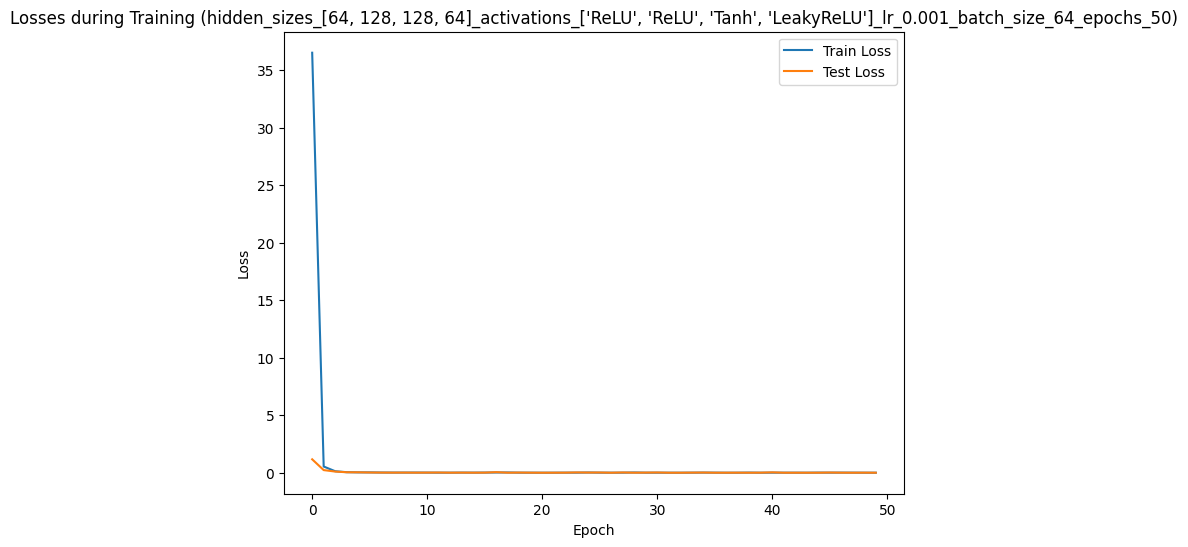

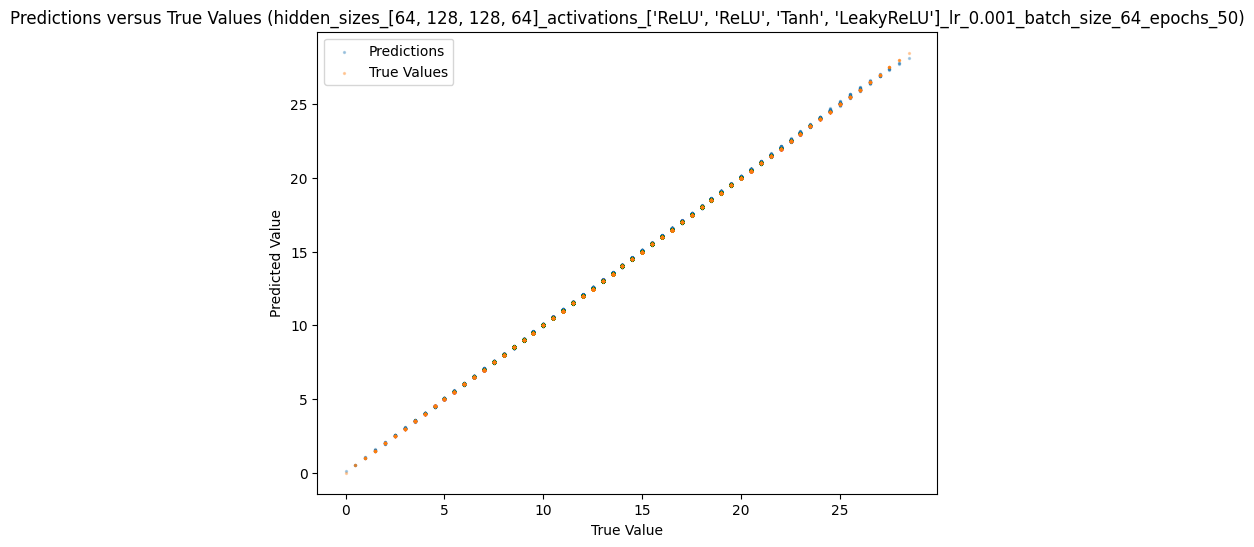

Approximating function g
Epoch 1, Train Loss: 112055.6283
Epoch 1, Test Loss: 76248.4844
Epoch 2, Train Loss: 43143.1654
Epoch 2, Test Loss: 18721.3789
Epoch 3, Train Loss: 9455.6179
Epoch 3, Test Loss: 3911.3240
Epoch 4, Train Loss: 2214.9610
Epoch 4, Test Loss: 1179.6050
Epoch 5, Train Loss: 752.4176
Epoch 5, Test Loss: 456.7650
Epoch 6, Train Loss: 468.0203
Epoch 6, Test Loss: 217.0863
Epoch 7, Train Loss: 171.7443
Epoch 7, Test Loss: 118.7810
Epoch 8, Train Loss: 123.8388
Epoch 8, Test Loss: 75.3013
Epoch 9, Train Loss: 81.2181
Epoch 9, Test Loss: 42.8671
Epoch 10, Train Loss: 50.2708
Epoch 10, Test Loss: 42.3092
Epoch 11, Train Loss: 106.5162
Epoch 11, Test Loss: 30.6497
Epoch 12, Train Loss: 68.6615
Epoch 12, Test Loss: 249.8548
Epoch 13, Train Loss: 110.5599
Epoch 13, Test Loss: 40.7375
Epoch 14, Train Loss: 55.3535
Epoch 14, Test Loss: 98.6363
Epoch 15, Train Loss: 104.1288
Epoch 15, Test Loss: 27.3289
Epoch 16, Train Loss: 28.2625
Epoch 16, Test Loss: 18.4261
Epoch 17, Train L

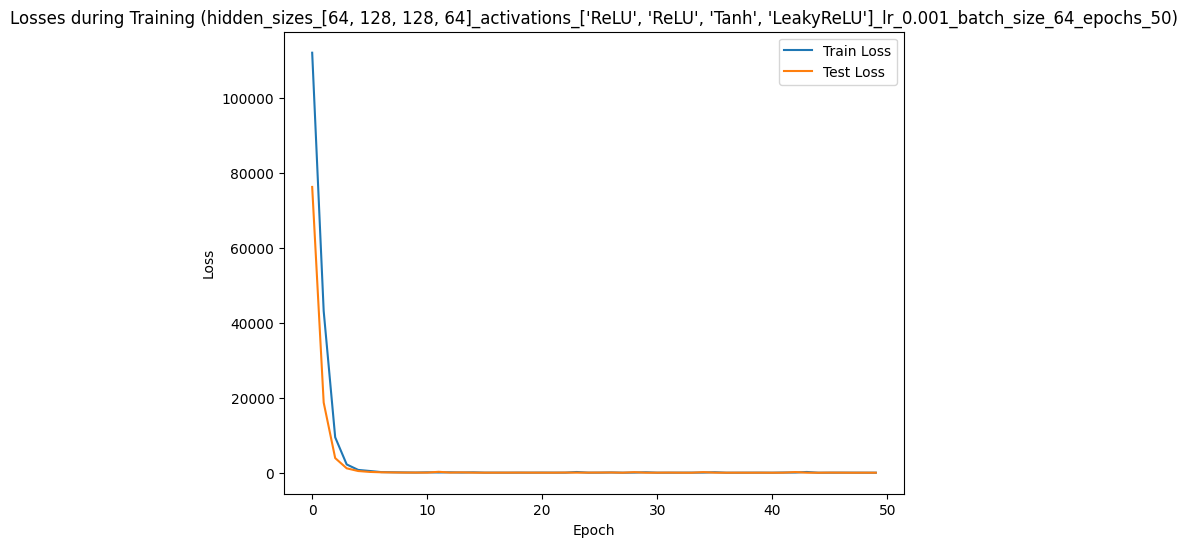

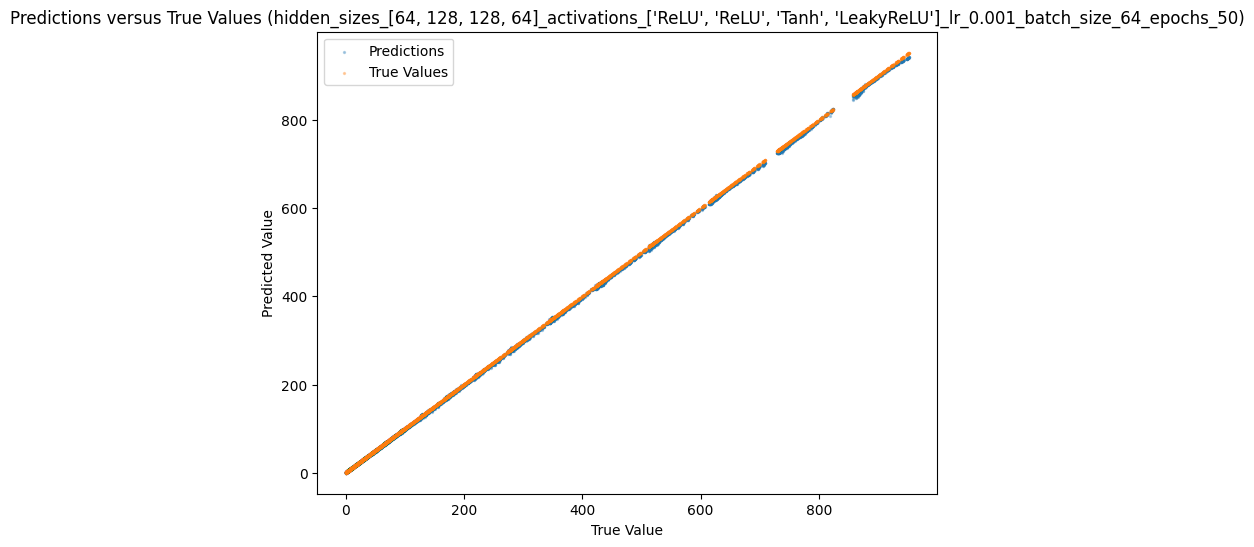

Approximating function h
Epoch 1, Train Loss: 500558596163674048.0000
Epoch 1, Test Loss: 500558647139500032.0000
Epoch 2, Train Loss: 500558584998050944.0000
Epoch 2, Test Loss: 500558509700546560.0000
Epoch 3, Train Loss: 500558533645207360.0000
Epoch 3, Test Loss: 500558440981069824.0000
Epoch 4, Train Loss: 500558442452108736.0000
Epoch 4, Test Loss: 500558406621331456.0000
Epoch 5, Train Loss: 500558334007040832.0000
Epoch 5, Test Loss: 500558303542116352.0000
Epoch 6, Train Loss: 500558233577770176.0000
Epoch 6, Test Loss: 500558131743424512.0000
Epoch 7, Train Loss: 500558083812277376.0000
Epoch 7, Test Loss: 500557925584994304.0000
Epoch 8, Train Loss: 500557918104847360.0000
Epoch 8, Test Loss: 500557822505779200.0000
Epoch 9, Train Loss: 500557722335733376.0000
Epoch 9, Test Loss: 500557650707087360.0000
Epoch 10, Train Loss: 500557528185964608.0000
Epoch 10, Test Loss: 500557410188918784.0000
Epoch 11, Train Loss: 500557297042795264.0000
Epoch 11, Test Loss: 5005571696707502

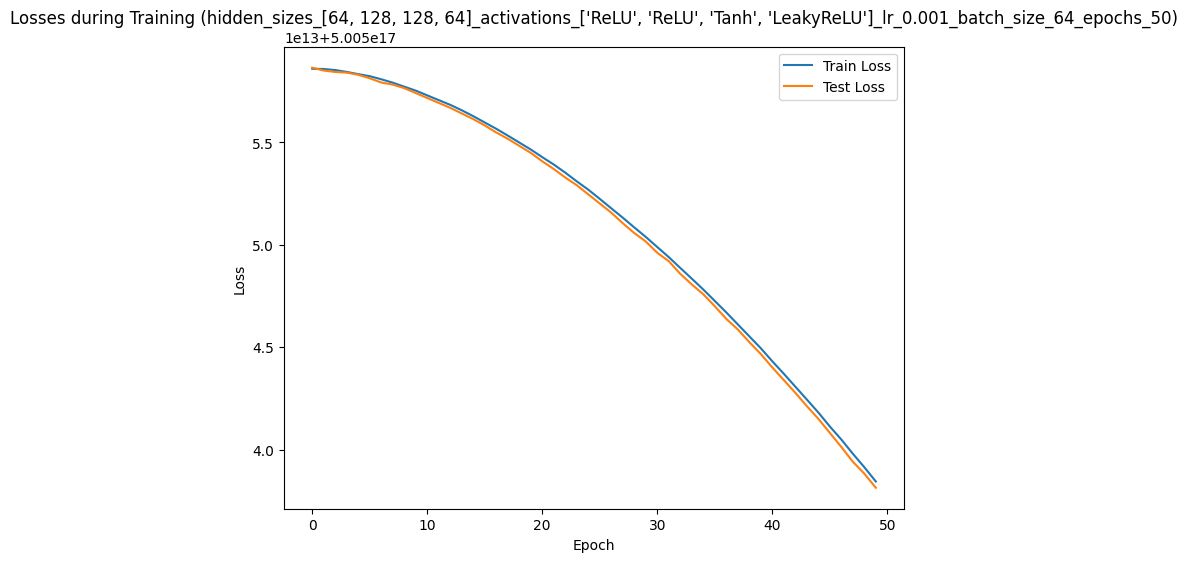

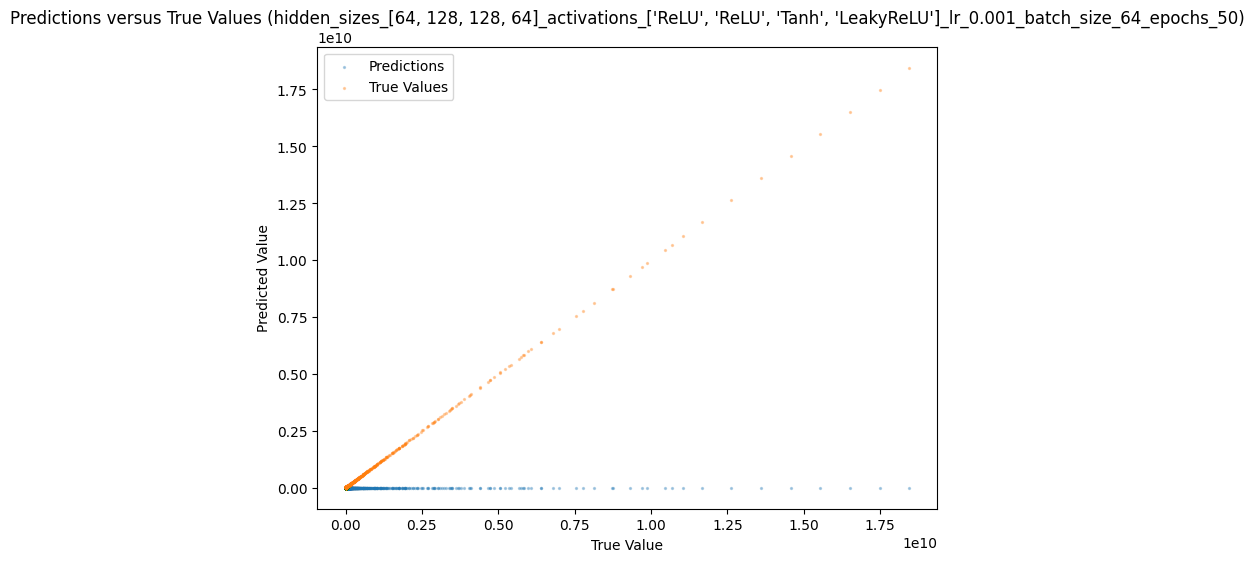

In [34]:

# Define a list of functions to be approximated
functions = [f, g, h]
# Define a list of function names for printing and plotting purposes
function_names = ["f", "g", "h"]
# Define a list of output tensors for each function
outputs = [Y_f, Y_g, Y_h]
# Define a list of output tensors for each function for train and test sets
outputs_train = [Y_f_train, Y_g_train, Y_h_train]
outputs_test = [Y_f_test, Y_g_test, Y_h_test]

# Loop over each function to be approximated
for i in range(len(functions)):
    # Print the function name
    print(f"Approximating function {function_names[i]}")
    # Create a neural network with given hyperparameters
    input_size = 3 # The number of input variables (x1, x2, x3)
    output_size = 1 # The number of output variables (y)
    # Create a network with 3 hidden layers and ReLU activations, and an optional output activation
    hidden_sizes = [64, 128, 128, 64]
    activations = [nn.ReLU, nn.ReLU, nn.Tanh, nn.LeakyReLU]
    output_activation = None
    model = create_network(input_size, output_size,
                        hidden_sizes, activations, output_activation=output_activation)

    # Create an instance of VariableNetwork by passing the model
    network = VariableNetwork(model)

    # Create an optimizer with given hyperparameters
    optimizer = optim.Adam(network.parameters(), lr=0.001)
    # Create a loss function with given hyperparameters
    loss_fn = nn.MSELoss()
    # Train the network with given hyperparameters and data
    batch_size = 64 # The number of samples in each batch
    epochs = 50 # The number of times to loop over the whole dataset
    # Create a string representation of the hyperparameters
    hyperparameters_str = f"hidden_sizes_{hidden_sizes}_activations_{[act.__name__ for act in activations]}_lr_{optimizer.param_groups[0]['lr']}_batch_size_{batch_size}_epochs_{epochs}"
    if output_activation:
        hyperparameters_str += f"_output_activation_{output_activation.__name__}"

    train_losses, test_losses = train_network(network, optimizer, loss_fn,
                                            batch_size, epochs,
                                            X_train.dataset, outputs_train[i].dataset,
                                            X_test.dataset, outputs_test[i].dataset)
    plot_losses(train_losses, test_losses, function_names[i], hyperparameters=hyperparameters_str)
    plot_predictions(network, X, outputs[i], function_names[i], hyperparameters=hyperparameters_str)

    # Save the network with hyperparameters in the file name
    torch.save(network, f"network_{function_names[i]}_{hyperparameters_str}.pt")
